![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Tutorial

This notebook is the second of two that demonstrate pixels-to-actions training using the experimental Madrona rendering backend.

### Usage

Please note that this Colab **does not support a hosted runtime**. To use it, please install [Madrona-MJX](https://github.com/shacklettbp/madrona_mjx/tree/main) and Playground on your local device and select `Connect to a local runtime`, or download the notebook to run locally! We recommend a device with at least 24 GB VRAM, such as the RTX4090.

In [ ]:
import os
# On your second reading, load the compiled rendering backend to save time!
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "<YOUR_PATH>/madrona_mjx/build/cache"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" # Ensure that Madrona gets the chance to pre-allocate memory before Jax

In [2]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools

from brax.training.agents.ppo import networks_vision as ppo_networks_vision
from brax.training.agents.ppo import train as ppo
from flax import linen
from IPython.display import clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import numpy as np

from mujoco_playground import manipulation
from mujoco_playground import wrapper
from mujoco_playground._src.manipulation.franka_emika_panda import randomize_vision as randomize
from mujoco_playground.config import manipulation_params

np.set_printoptions(precision=3, suppress=True, linewidth=100)

## Picking up a Cube from Pixels

[Madrona MJX](https://github.com/shacklettbp/madrona_mjx/tree/main) is Mujoco's experimental on-device rendering backend, developed in collaboration with [Madrona](https://github.com/shacklettbp/madrona). It implements a JAX-compatible batched renderer for rolling out multiple training environments in parallel.

*Domain Randomization*

Just like in physics simulation, the mismatch between the simulated environment that the policy is trained on and the real-world setting in which it is deployed can be minimised either by meticulously calibrating the simulation or by randomizing simulation parameters such that the policy learns to be robust to a wide variety of ranges. Madrona MJX supports domain randomisation, rendering different camera poses and geometry appearances across parallel environments.

*Coming up*

While batched renderers such as Madrona MJX are much faster than traditional rendering workflows, end-to-end pixel-based training remains several times slower than the state-based counterpart due to costlier neural network architectures and rendering overhead.

To keep the runtime for this task short and to simplify real-world transfer, we've adapted the [bring_to_target](https://github.com/kevinzakka/mujoco_playground/blob/main/mujoco_playground/_src/manipulation/franka_emika_panda/bring_to_target.py) task to the 2D case and introduce a task-space controller. These changes allow the policy to converge in well under ten million samples using a low-resolution single-camera RGB input. Collaborators from the [MedCVR](https://medcvr.utm.utoronto.ca/) lab have used this code for [real-world deployment](https://www.youtube.com/watch?v=Y_lHJDttlHY).

In [ ]:
env_name = "PandaPickCubeCartesian"
env_cfg = manipulation.get_default_config(env_name)

num_envs = 1024
episode_length = int(4 / env_cfg.ctrl_dt)

# Rasterizer is less feature-complete than ray-tracing backend but stable
config_overrides = {
    "episode_length": episode_length,
    "vision": True,
    "obs_noise.brightness": [0.75, 2.0],
    "vision_config.use_rasterizer": False,
    "vision_config.render_batch_size": num_envs,
    "vision_config.render_width": 64,
    "vision_config.render_height": 64,
    "box_init_range": 0.1, # +- 10 cm
    "action_history_length": 5,
    "success_threshold": 0.03
}

env = manipulation.load(env_name, config=env_cfg, 
                        config_overrides=config_overrides
)
randomization_fn = functools.partial(randomize.domain_randomize,
                                        num_worlds=num_envs
)
env = wrapper.wrap_for_brax_training(
    env,
    vision=True,
    num_vision_envs=num_envs,
    episode_length=episode_length,
    action_repeat=1,
    randomization_fn=randomization_fn
)

#### Visualize the Environment

To make our policy robust to differences between the simulation environment and reality, we randomize the colors of the background and the target as well as the camera pose.

In [4]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)

def unvmap(x):
    return jax.tree.map(lambda y: y[0], x)

""

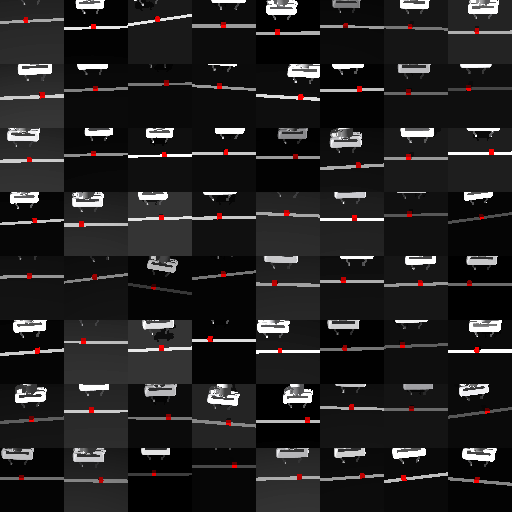

In [5]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
media.show_image(tile(state.obs['pixels/view_0'][:64], 8), width=512)

To improve sample efficiency and facilitate real-world transfer, we use a cartesian action space in the y and z dimensions. This conditions out the underlying physics and removes the need for a stereo camera setup or depth sensor. We additionally discretize the gripper's action space so that it's fully opened or closed.

In [ ]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
rollout = [unvmap(state)]

f = 0.2
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            unvmap(state.data.time) * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.tile(jp.array(action), (num_envs, 1))
  state = jit_step(state, action)
  rollout.append(unvmap(state))

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

## Train

The policy trains in 7 min 4 sec on a RTX 4090 GPU.

In [ ]:
network_factory = functools.partial(
    ppo_networks_vision.make_ppo_networks_vision,
    policy_hidden_layer_sizes=[256, 256],
    value_hidden_layer_sizes= [256, 256],
    activation=linen.relu,
    normalise_channels=True
)

ppo_params = manipulation_params.brax_vision_ppo_config(env_name)
ppo_params.num_timesteps = 7_000_000
ppo_params.num_envs = num_envs
ppo_params.num_eval_envs = num_envs
del ppo_params.network_factory
ppo_params.network_factory = network_factory

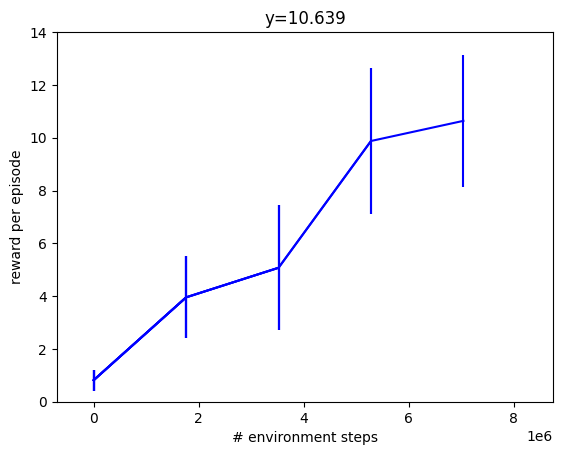

time to jit: 0:00:35.598510
time to train: 0:06:55.076988


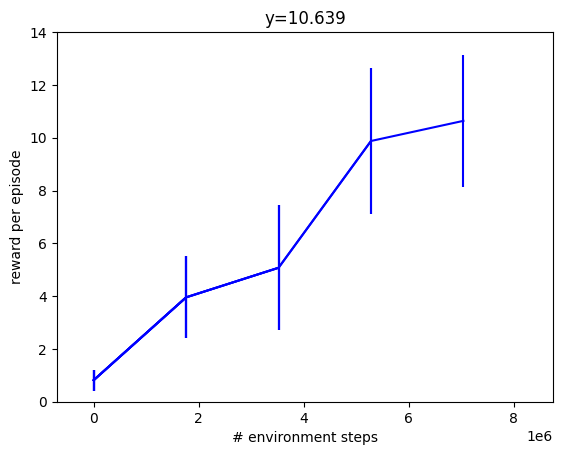

In [7]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  steps = ppo_params["num_timesteps"]
  plt.xlim([steps * -0.1, steps * 1.25])
  plt.ylim([0, 14])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


train_fn = functools.partial(
    ppo.train,
    augment_pixels=True,
    **dict(ppo_params),
    progress_fn=progress
)

make_inference_fn, params, metrics = train_fn(environment=env)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

#### Visualize Policy

In [9]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

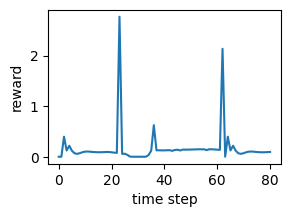

In [10]:
rng = jax.random.PRNGKey(0)
rollout = []
n_episodes = 1
to_keep = 256

def keep_until(state, i):
    return jax.tree.map(lambda x: x[:i], state)

for _ in range(n_episodes):
    key_rng = jax.random.split(rng, num_envs)
    state = jit_reset(key_rng)
    rollout.append(keep_until(state, to_keep))
    for i in range(env_cfg.episode_length):
        act_rng, rng = jax.random.split(rng)
        act_rng = jax.random.split(act_rng, num_envs)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        rollout.append(keep_until(state, to_keep))

render_every = 1
frames = env.render([unvmap(s) for s in rollout][::render_every])
rewards = [unvmap(s).reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)
plt.figure(figsize=(3, 2))
plt.plot(rewards)
plt.xlabel("time step")
plt.ylabel("reward")
plt.show()

As a finale, let's peek at some of the worlds our policy has been training in:

In [11]:
obs = [np.array(s.obs['pixels/view_0']) for s in rollout]
obs = [tile(img, int(np.sqrt(to_keep))) for img in obs]
media.show_video(obs, fps=1.0/env_cfg.ctrl_dt, width=512)